In [272]:
# Import standard libraries
import base64
from datetime import datetime, timedelta
import json
import os
os.environ['USE_PYGEOS'] = '0'
import sys
import yaml

# Import installed libraries
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from pyproj.crs import CRS
from pystac_client import Client
import xarray as xr
import seaborn as sns
from shapely.geometry import Point, Polygon

# Import local modules
project_path = os.path.abspath(os.path.join('..'))
if project_path not in sys.path:
    sys.path.append(project_path)
from library import utils
from library.FH_Hydrosat import FH_Hydrosat, FH_StackedDataset

# Read configuration file
with open("../config.yml","r") as f:
    config = yaml.safe_load(f)

In [273]:
# import base64
# from datetime import datetime
# import json
# import os
# os.environ['USE_PYGEOS'] = '0'

# import contextily as ctx
# from FH_Hydrosat import FH_Hydrosat, FH_StackedDataset
# import geopandas as gpd
# import matplotlib.pyplot as plt
# import numpy as np
# import pandas as pd
# from pyproj.crs import CRS
# from pystac_client import Client
# import rasterio
# from rasterio.plot import show
# from rasterio.mask import mask
# from rasterio.windows import Window
# import rasterio
# import rioxarray
# from shapely.geometry import mapping
# import seaborn as sns
# from shapely.geometry import box, Point, Polygon
# import xarray as xr

In [274]:
# Specify crop type
met_tower = 'alfalfa'

# Define paths to data
data_dir = os.path.join('..', 'data', 'Ameriflux')
file_name = config[met_tower]['data_params']['file_name']
file_path = os.path.join(data_dir, file_name)

# Read data
bi1_df = utils.read_ameriflux(file_path)
print(f'Data range from {bi1_df.index.min()} to {bi1_df.index.max()}')


Data range from 2016-08-13 00:00:00 to 2022-12-31 23:30:00


In [275]:
# Authenticate and access catalog
with open(os.path.join('..', 'secrets', 'creds.json')) as f:
    creds = json.loads(f.read())
    
userpass = f"{creds['username']}:{creds['password']}"
b64 = base64.b64encode(userpass.encode()).decode()
headers = {'Authorization':'Basic ' + b64}

cat_url = 'https://fusion-stac.hydrosat.com'
catalog = Client.open(cat_url, headers)

In [276]:
# Set up collections dictionary
collections_dict = {
    'collection': ['prepped_inputs_s2',
                   'prepped_inputs_mcd43a4',
                   'prepped_inputs_vnp43ia4',
                   'prepped_inputs_landsat',
                   'prepped_inputs_mod21a1d',
                   'pydms_sharpened_modis',
                   'pydms_sharpened_landsat',
                   'starfm_predictions_modis_s2',
                   'prepped_inputs_vnp21a1d',
                   'pydms_sharpened_viirs',
                   'starfm_predictions_modis_landsat'],
    'asset': ['surface_reflectance',
              'surface_reflectance',
              'surface_reflectance',
              'lst',
              'lst',
              'lst',
              'lst',
              'lst',
              'lst',
              'lst',
              'lst'],
    'tolerance': [40, 1000, 1000, 60, 2000, 1000, 60, 40, 1000, 1000, 40],
    'red_band': [2, 0, None, None, None, None, None,  None,  None, None,  None],
    'nir_band': [6, 1, None, None, None,  None, None,  None, None, None,  None]
}
collections_df = pd.DataFrame(collections_dict)
collections_df

,collection,asset,tolerance,red_band,nir_band
0,prepped_inputs_s2,surface_reflectance,40,2.0,6.0
1,prepped_inputs_mcd43a4,surface_reflectance,1000,0.0,1.0
2,prepped_inputs_vnp43ia4,surface_reflectance,1000,NaN,NaN
3,prepped_inputs_landsat,lst,60,NaN,NaN
4,prepped_inputs_mod21a1d,lst,2000,NaN,NaN
5,pydms_sharpened_modis,lst,1000,NaN,NaN
6,pydms_sharpened_landsat,lst,60,NaN,NaN
7,starfm_predictions_modis_s2,lst,40,NaN,NaN
8,prepped_inputs_vnp21a1d,lst,1000,NaN,NaN
9,pydms_sharpened_viirs,lst,1000,NaN,NaN


In [277]:
geom = {'type': 'Point', 'coordinates': config[met_tower]['field_center']}
pt = Point(geom['coordinates'])
poly = Polygon(config[met_tower]['aoi_coordinates'])
poly_gdf = gpd.GeoDataFrame({'geometry':[poly]}, crs=CRS.from_epsg(4326))
poly_gdf = poly_gdf.to_crs(crs = CRS.from_epsg(32610))
poly_gdf_buffer = poly_gdf.buffer(1000)

start_date = "2022-01-01T00:00:00Z"
end_date = "2022-12-31T00:00:00Z"

aoi = pt
collection = 'prepped_inputs_s2'
asset = 'surface_reflectance'
rbg_bands = [2,1,0]  # [0,3,2] 
nir_band = 0  # 1

In [278]:
if type(aoi) == Point:
    search = catalog.search(
        collections=collection,
        intersects=geom,
        datetime=[start_date, end_date],
        max_items=1000
    )
elif type(aoi) == Polygon:
    search = catalog.search(
        collections=collection,
        aoi=geom,
        datetime=[start_date, end_date],
        max_items=1000
    )

items = search.get_all_items()
print(f'number of source {collection} items: {len(items)}')

number of source prepped_inputs_s2 items: 66


In [279]:
items[0].to_dict()['assets'].keys()

dict_keys(['surface_reflectance', 'surface_reflectance_qa', 'valid_data_mask', 'combined_qa', 'preview', 'thumbnail'])

## Clipping
We'll need to clip the data efficiently across the time dimension to plot and calculate aereal statistics. We can clip with rasterio (faster for single image) or rioxarray (faster with time series due to use of `dask`).

### Clipping the data array on read with rasterio
This method clips a single image using rasterio. Update the dims parameter to reflect the data shape (e.g., "lst" has two dimensions (dims="y", "x"), "surface_reflectance" has three dimensions (dims="band", "y", "x")). This method is considerably faster for one image than using rioxarray as it only loads the data within the clip from the stack, rather than loading all data from the tile and then clipping. However it is slower when loading the entire time series.

In [280]:
itemjson = items.to_dict()
filepath = itemjson["features"][1]["assets"][asset]["href"]

with rasterio.open(filepath) as src:
    out_image, out_transform = rasterio.mask.mask(src, poly_gdf_buffer.geometry.apply(mapping), crop=True)
    out_meta = src.meta

# Update metadata after mask
out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

# Assign coordinate values from out_meta
coords = {
    "x": out_meta["transform"].c + out_meta["transform"].a * np.arange(out_meta["width"]),
    "y": out_meta["transform"].f + out_meta["transform"].e * np.arange(out_meta["height"])
}

# Create a new DataArray with updated coordinates
rio_clip = xr.DataArray(
    out_image.squeeze(),
    coords=coords,
    dims=("band", "y", "x"),  # Update dimensions as per your data shape
)

# Set the CRS (Coordinate Reference System) for the DataArray
rio_clip.rio.set_crs(out_meta["crs"])

<xarray.DataArray (band: 9, y: 128, x: 128)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
...
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)
Coordinates:
  * x        (x) float64 6.301e+05 6.301e+05 6.301e+05 ... 6.326e+05 6.326e+05
  * y        (y) float64 4.219e+06 4.219e+06 4.219e+06 ... 4.217e+06 4.217e+06
Dimensions without coordinates: band

Here we expand to clip the entire time series. This is much slower than using `dask` which is used in the FY_Hydrosat class.

In [281]:
itemjson = items.to_dict()
features = itemjson['features']

asset_list = {f["properties"]["datetime"] : f["assets"][asset]["href"] for f in features}

da_list = []

for timestamp in sorted(asset_list.keys()):   
    filepath = asset_list[timestamp]
    with rasterio.open(filepath) as src:
        out_image, out_transform = rasterio.mask.mask(src, poly_gdf_buffer.geometry.apply(mapping), crop=True)
        out_meta = src.meta

    # Update metadata after mask
    out_meta.update({"driver": "GTiff",
                    "height": out_image.shape[1],
                    "width": out_image.shape[2],
                    "transform": out_transform})
    try:
        timestamp_naive = datetime.strptime(timestamp, "%Y-%m-%dT%H:%M:%S.%fZ")
    except(ValueError):
        timestamp_naive = datetime.strptime(timestamp, "%Y-%m-%dT%H:%M:%SZ")


    # Assign coordinate values from out_meta
    coords = {
        "x": out_meta["transform"].c + out_meta["transform"].a * np.arange(out_meta["width"]),
        "y": out_meta["transform"].f + out_meta["transform"].e * np.arange(out_meta["height"]),
        "time": timestamp_naive
    }

    # Create a new DataArray with updated coordinates
    da = xr.DataArray(
        out_image.squeeze(),
        coords=coords,
        dims=("band", "y", "x"),  # Update dimensions as per your data shape
    )

    # # Set the CRS (Coordinate Reference System) for the DataArray
    # da.rio.set_crs(out_meta["crs"])

    # Append to da_list
    da_list.append(da)

# Concatenate all data arrays
rio_clip = xr.concat(da_list, dim='time')

### Clipping using rioxarray
This method uses rioxarray to clip the DataArray. For the time series, it performs much faster, probably by using `dask`.

In [282]:
res_full = FH_Hydrosat(items, asset=asset)
res_stack = res_full.stack()
res_clip = res_stack.ds.rio.clip(poly_gdf_buffer.geometry)

## Filter by date
We'll want to filter data to just the growing season. The timezone-aware timestamps that come with the data are creating issues. When clipping with rasterio, we've formatted the times to drop the timezone. With rioxarray, we have not. Note that in production we can filter during search if only searching for one year.

In [283]:
# Convert the timestamps to a NumPy datetime64 array
timestamps = rio_clip['time'].values

# Define the start and end dates
filter_start_date = np.datetime64('2022-04-01')
filter_end_date = np.datetime64('2022-08-31')

# Create a boolean mask for timestamps within the specified range
mask = (timestamps > filter_start_date) & (timestamps < filter_end_date)

# Use boolean indexing to select the images within the specified range
rio_clip_sel = rio_clip.sel(time=mask).sortby('time')


In [284]:
# Convert the timestamps to a NumPy datetime64 array
timestamps = res_clip['time'].values

# Define the start and end dates
filter_start_date = np.datetime64('2022-04-01')
filter_end_date = np.datetime64('2022-08-31')

# Create a boolean mask for timestamps within the specified range
mask = (timestamps > filter_start_date) & (timestamps < filter_end_date)

# Use boolean indexing to select the images within the specified range
res_clip_sel = res_clip.sel(time=mask).sortby('time')


C:\Users\Erik_Anderson\AppData\Local\Temp\ipykernel_35716\948460163.py:9: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  mask = (timestamps > filter_start_date) & (timestamps < filter_end_date)


## Plot RGB
To plot the RBG, we need to first normalize the Sentinel 2 data. Band mapping is red=2, green=1, blue=0 (zero indexed).

In [285]:
def normalize(arr):
    return (arr - arr.min()) / (arr.max() - arr.min())

Here we plot the first image of the data array clipped with rasterio.

c:\Users\Erik_Anderson\miniconda3\envs\geo\lib\site-packages\matplotlib\cm.py:344: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


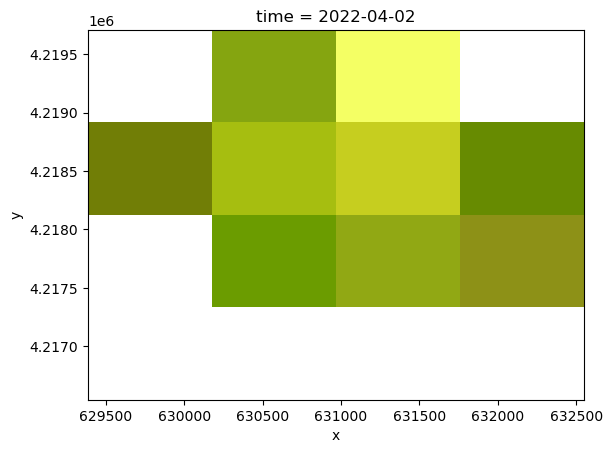

In [246]:
rio_clip_sel_rgb = normalize(rio_clip_sel.isel(band=rbg_bands))
rio_clip_sel_rgb[0].plot.imshow(robust=True, rgb='band')

Here we plot using the data array clipped using rioxarray.

c:\Users\Erik_Anderson\miniconda3\envs\geo\lib\site-packages\matplotlib\cm.py:344: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


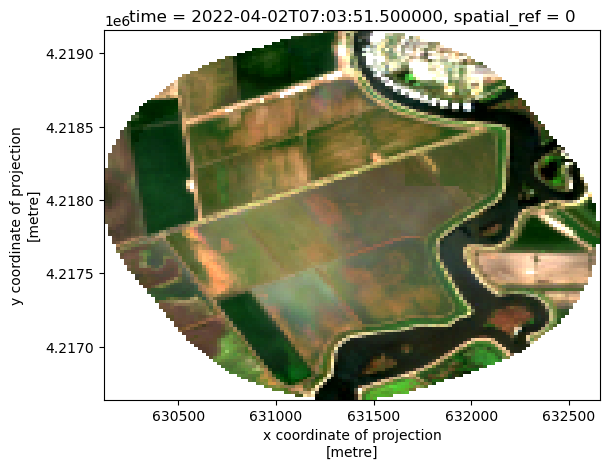

In [136]:
res_clip_sel_rgb = normalize(res_clip_sel.isel(band=rbg_bands))
res_clip_sel_rgb[0].plot.imshow(robust=True)

### RGB time series
Let's plot the entire time series within the growing season. First we'll need to filter to the growing season.

IndexError: index 28 is out of bounds for axis 0 with size 28

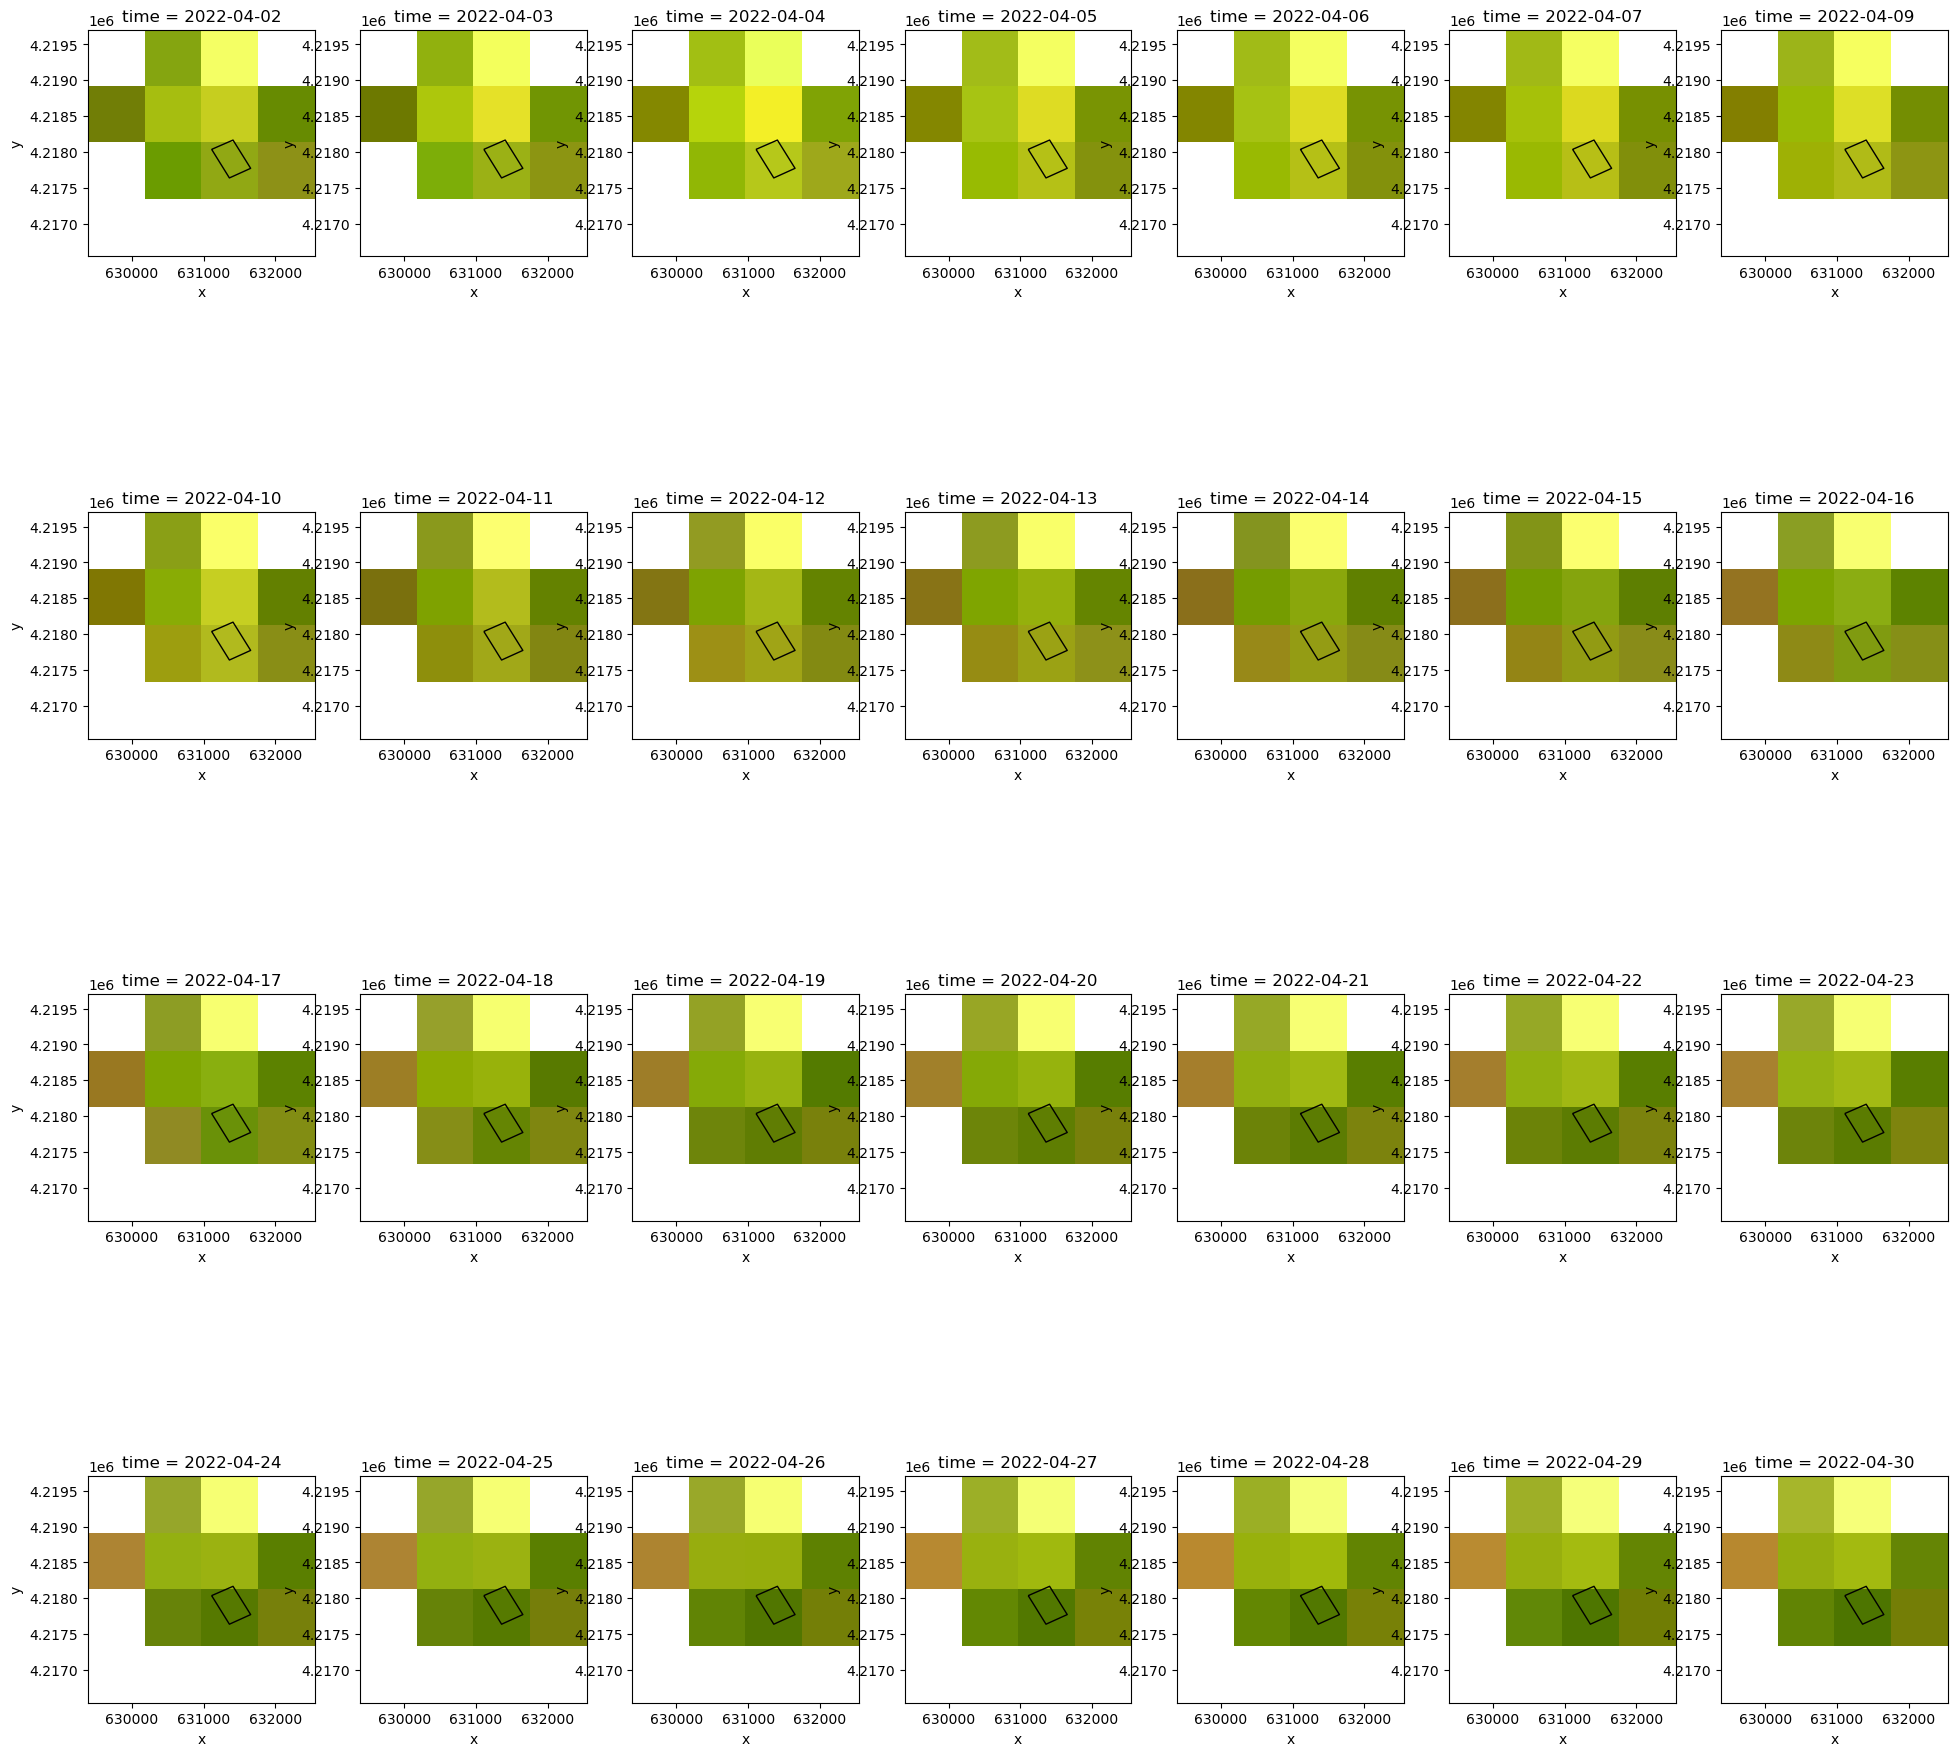

In [251]:
fig, axes = plt.subplots(4,7, figsize=(24,24))
axes = axes.flat

for i, timestamp in enumerate(rio_clip_sel_rgb['time']):
    image = rio_clip_sel_rgb.sel(time=timestamp)
    image.plot.imshow(ax=axes[i], robust=True, rgb='band')
    poly_gdf.plot(ax=axes[i], facecolor='none', edgecolor='black')

## NDVI from imagery
Next, we'll calculate the NDVI for each scene in the data array.

### NDVI from data array clipped by rasterio

In [248]:
def calc_ndvi(ds, red_band, nir_band):
    red = ds.sel(band=red_band)
    nir = ds.sel(band=nir_band)
    ndvi = (nir - red) / (nir + red)
    return ndvi

In [249]:
rio_clip_sel_ndvi = calc_ndvi(rio_clip_sel, rbg_bands[0], nir_band)

IndexError: index 28 is out of bounds for axis 0 with size 28

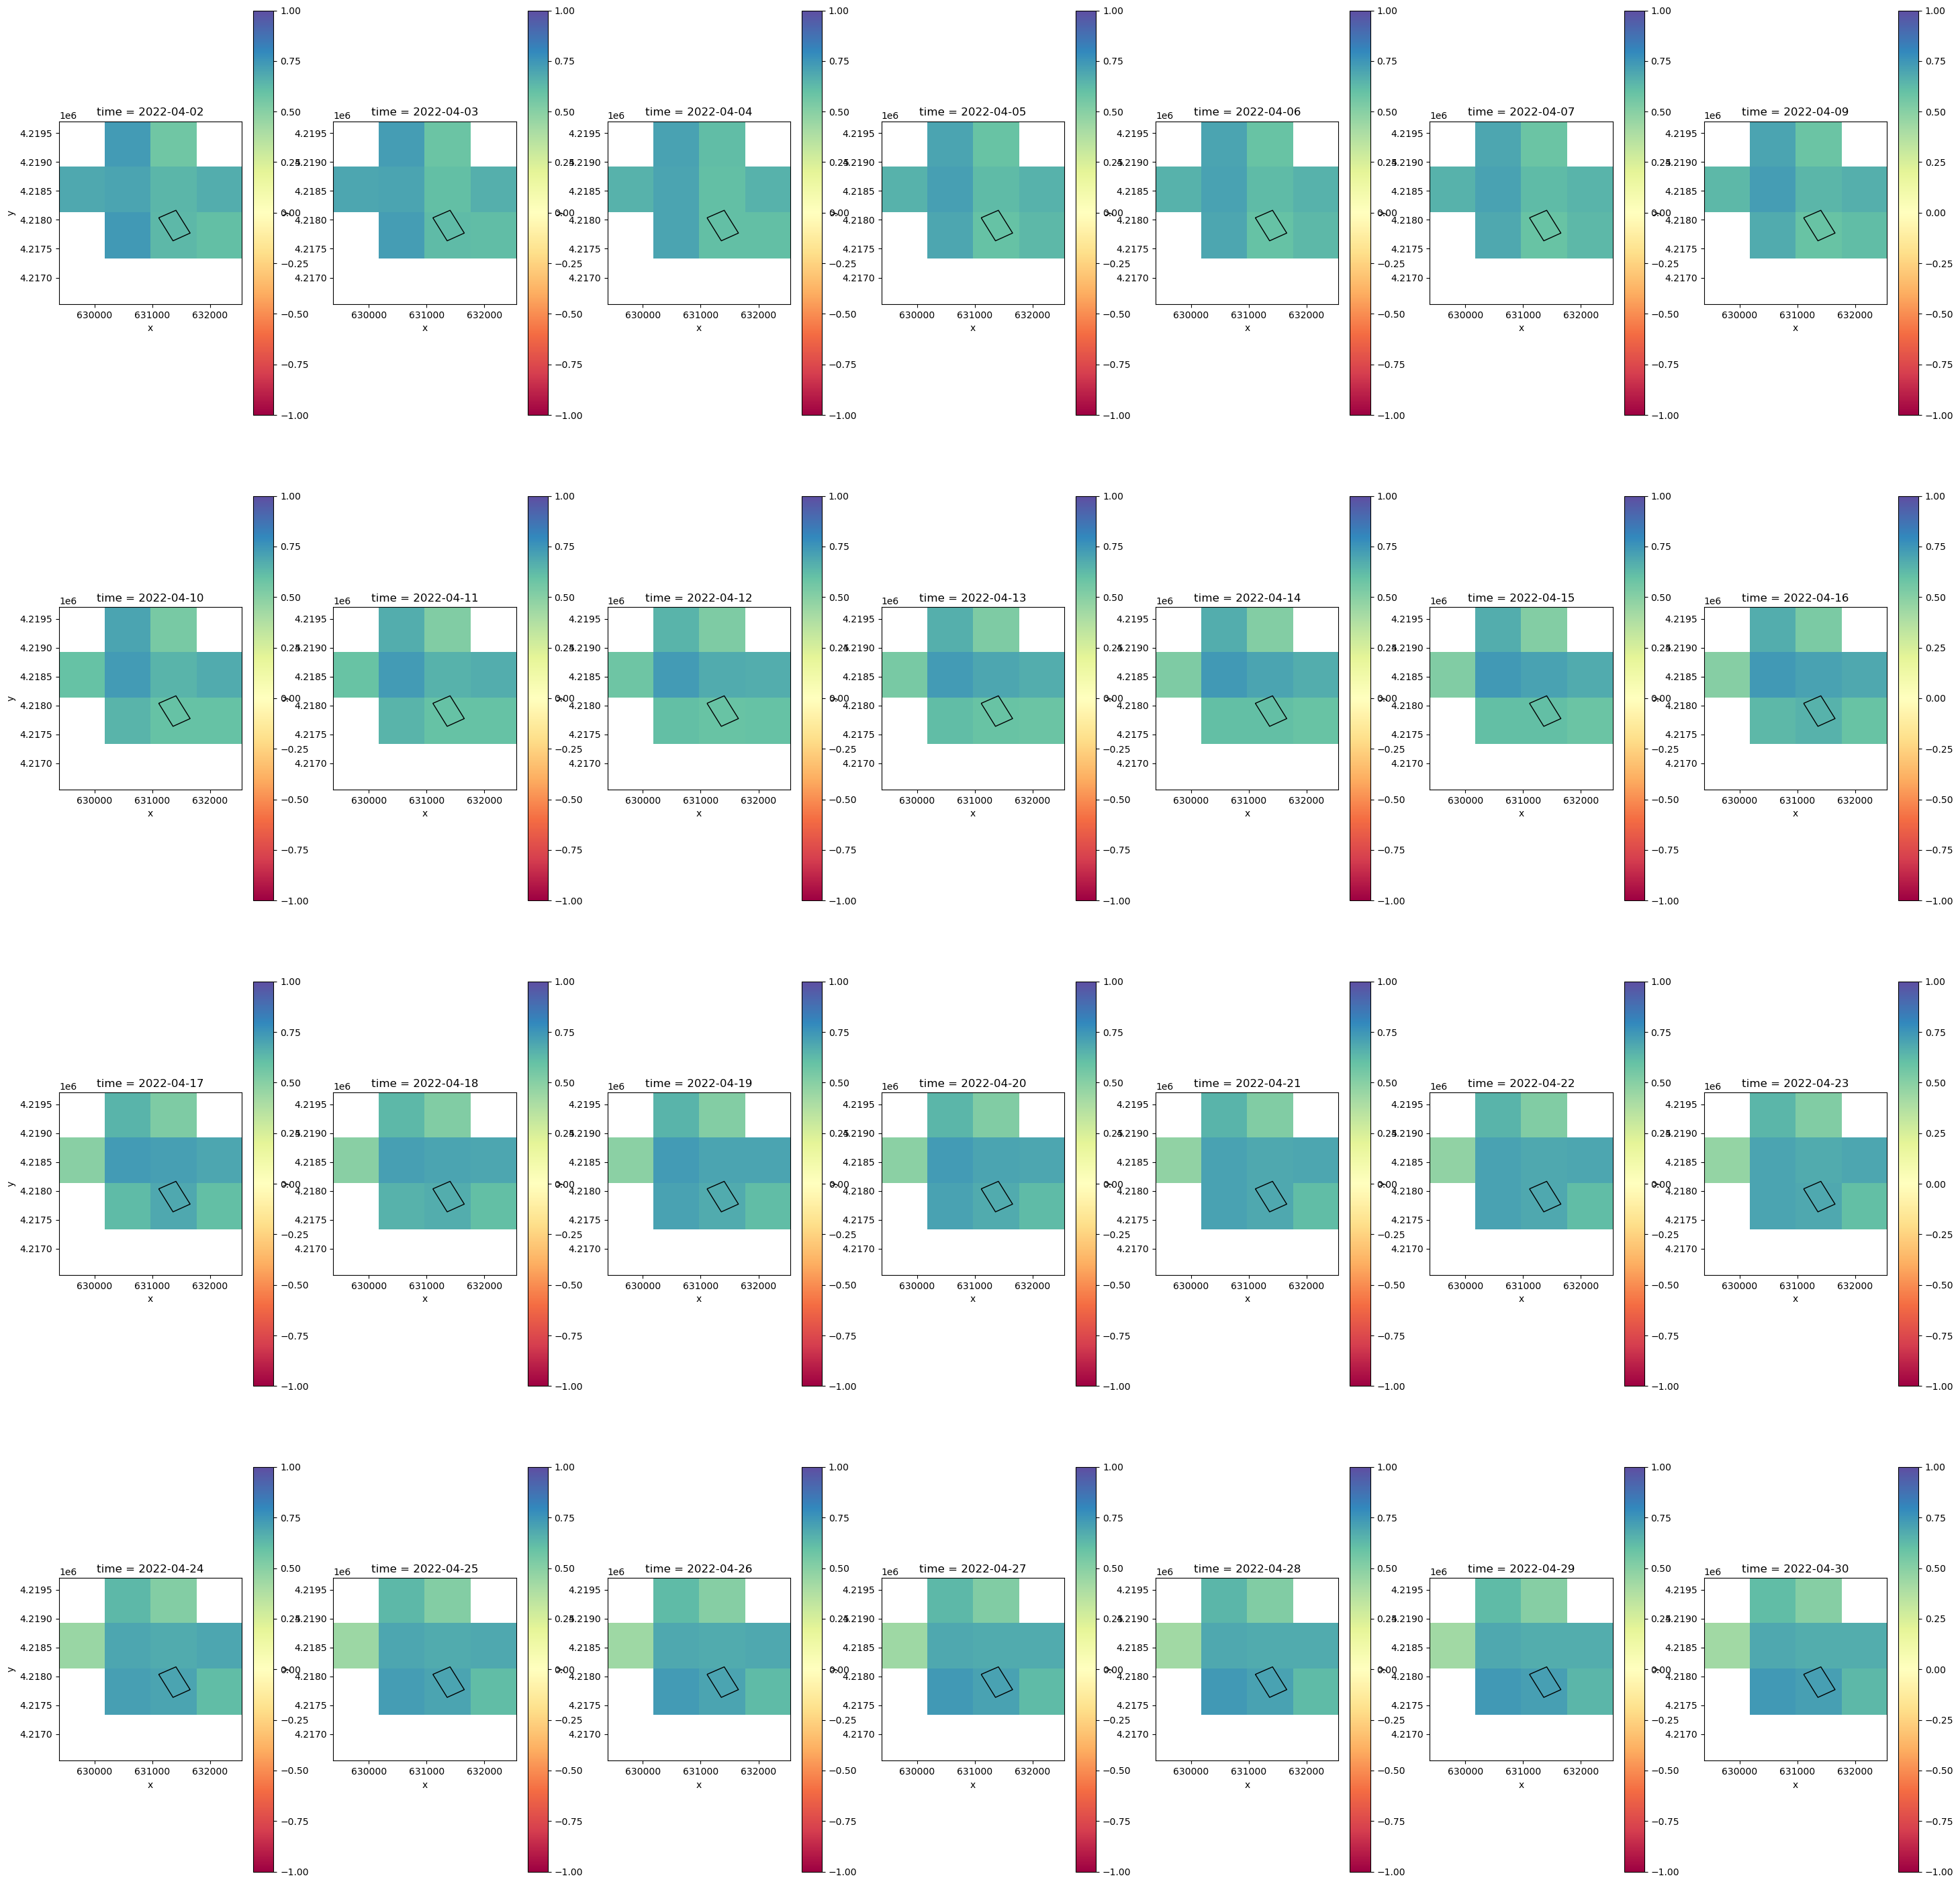

In [250]:
fig, axes = plt.subplots(4,7, figsize=(36,36))
axes = axes.flat

for i, timestamp in enumerate(rio_clip_sel_ndvi['time']):
    image = rio_clip_sel_ndvi.sel(time=timestamp)
    image.plot.imshow(ax=axes[i], robust=True, cmap='Spectral', vmin=-1, vmax=1)
    poly_gdf.plot(ax=axes[i], facecolor='none', edgecolor='black')

plt.tight_layout()
plt.show();

We can see above that the NDVI from the Sentinel 2 imagery is reflecting the aerial imagery closely. We'll want to compare the NDVI from the tower for these specific dates to confirm that the tower NDVI is also reflecting what we see on the ground.

## Tower NDVI
We've developed the code to extract tower NDVI in `exploration/ndvi-exploration.ipynb`.

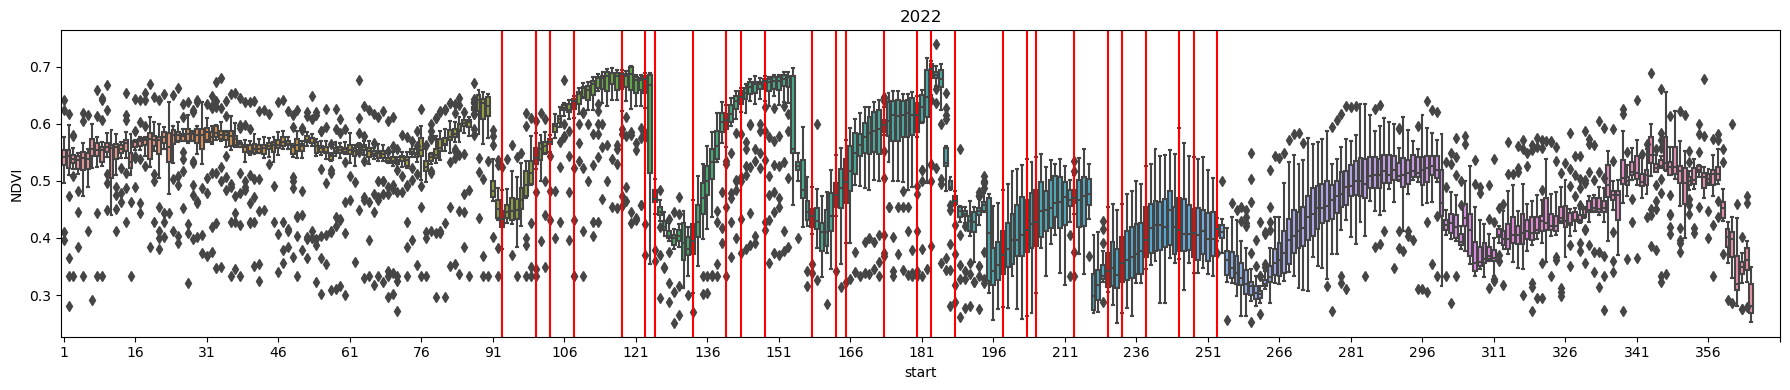

In [154]:
filt = (bi1_df['NDVI'] > 0.25) &  (bi1_df['NDVI'] < 0.75)
year = 2022

fig, ax = plt.subplots(figsize=(18, 4))
df = bi1_df.loc[filt]
df_year = df.loc[df.index.year == year]
sns.boxplot(x=df_year.index.dayofyear,
            y=df_year['NDVI'],
            ax=ax).set(title=year)

# df.loc[filt2].groupby(df_year.index.dayofyear)['NDVI'].mean().plot(ax=ax, color='k')
plt.xticks(range(0,365,15))

for timestamp in res_clip_sel['time'].values:
    ax.axvline(x=timestamp.dayofyear, ymin=0, ymax=1, color='r')

plt.tight_layout();

The story told by the tower NDVI is nothing like what we're seeing in the rgb imagery or the NDVI imagery. Both of the imagery products shows a field that experiences an initial greening and then a significant dry up. The Tower NDVI suggests a series of harvests throughout the growing season.

## LST 
Next we'll compare LST to the RGB and NDVI images.

In [197]:
collection = 'starfm_predictions_modis_landsat'
asset = 'lst'

if type(aoi) == Point:
    search = catalog.search(
        collections=collection,
        intersects=geom,
        datetime=[start_date, end_date],
        max_items=1000
    )
elif type(aoi) == Polygon:
    search = catalog.search(
        collections=collection,
        aoi=geom,
        datetime=[start_date, end_date],
        max_items=1000
    )

items = search.get_all_items()
print(f'number of source {collection} items: {len(items)}')

number of source starfm_predictions_modis_landsat items: 259


In [198]:
itemjson = items.to_dict()
features = itemjson['features']

asset_list = {f["properties"]["datetime"]: f["assets"][asset]["href"] for f in features}

da_list = []

for timestamp in sorted(asset_list.keys()):   
    filepath = asset_list[timestamp]
    with rasterio.open(filepath) as src:
        out_image, out_transform = rasterio.mask.mask(src, poly_gdf_buffer.geometry.apply(mapping), crop=True)
        out_meta = src.meta

    # Update metadata after mask
    out_meta.update({"driver": "GTiff",
                    "height": out_image.shape[1],
                    "width": out_image.shape[2],
                    "transform": out_transform})
    try:
        timestamp_naive = datetime.strptime(timestamp, "%Y-%m-%dT%H:%M:%S.%fZ")
    except(ValueError):
        timestamp_naive = datetime.strptime(timestamp, "%Y-%m-%dT%H:%M:%SZ")


    # Assign coordinate values from out_meta
    coords = {
        "x": out_meta["transform"].c + out_meta["transform"].a * np.arange(out_meta["width"]),
        "y": out_meta["transform"].f + out_meta["transform"].e * np.arange(out_meta["height"]),
        "time": timestamp_naive
    }

    # Create a new DataArray with updated coordinates
    da = xr.DataArray(
        out_image.squeeze(),
        coords=coords,
        dims=("y", "x"),  # Update dimensions as per your data shape
    )

    # Set the CRS (Coordinate Reference System) for the DataArray
    da.rio.set_crs(out_meta["crs"])

    # Append to da_list
    da_list.append(da)

# Concatenate all data arrays
lst_clip = xr.concat(da_list, dim='time')

# Convert the timestamps to a NumPy datetime64 array
timestamps = lst_clip['time'].values

# Define the start and end dates
filter_start_date = np.datetime64('2022-04-01')
filter_end_date = np.datetime64('2022-08-31')

# Create a boolean mask for timestamps within the specified range
mask = (timestamps > filter_start_date) & (timestamps < filter_end_date)

# Use boolean indexing to select the images within the specified range
lst_clip_sel = lst_clip.sel(time=mask).sortby('time')

In [201]:
asset_list.keys()

dict_keys(['2022-12-31T00:00:00Z', '2022-12-28T00:00:00Z', '2022-12-27T00:00:00Z', '2022-12-26T00:00:00Z', '2022-12-25T00:00:00Z', '2022-12-24T00:00:00Z', '2022-12-23T00:00:00Z', '2022-12-20T00:00:00Z', '2022-12-19T00:00:00Z', '2022-12-18T00:00:00Z', '2022-12-17T00:00:00Z', '2022-12-16T00:00:00Z', '2022-12-15T00:00:00Z', '2022-12-12T00:00:00Z', '2022-12-11T00:00:00Z', '2022-12-10T00:00:00Z', '2022-12-09T00:00:00Z', '2022-12-08T00:00:00Z', '2022-12-07T00:00:00Z', '2022-12-04T00:00:00Z', '2022-12-03T00:00:00Z', '2022-12-02T00:00:00Z', '2022-12-01T00:00:00Z', '2022-11-30T00:00:00Z', '2022-11-29T00:00:00Z', '2022-11-26T00:00:00Z', '2022-11-25T00:00:00Z', '2022-11-24T00:00:00Z', '2022-11-23T00:00:00Z', '2022-11-22T00:00:00Z', '2022-11-21T00:00:00Z', '2022-11-18T00:00:00Z', '2022-11-17T00:00:00Z', '2022-11-16T00:00:00Z', '2022-11-15T00:00:00Z', '2022-11-14T00:00:00Z', '2022-11-13T00:00:00Z', '2022-11-10T00:00:00Z', '2022-11-09T00:00:00Z', '2022-11-08T00:00:00Z', '2022-11-07T00:00:00Z', '2022

In [213]:
res_clip_sel['time'].values.astype('datetime64[D]')

C:\Users\Erik_Anderson\AppData\Local\Temp\ipykernel_35716\2520018908.py:1: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  res_clip_sel['time'].values.astype('datetime64[D]')


array(['2022-04-02', '2022-04-09', '2022-04-12', '2022-04-17',
       '2022-04-27', '2022-05-02', '2022-05-04', '2022-05-12',
       '2022-05-19', '2022-05-22', '2022-05-27', '2022-06-06',
       '2022-06-11', '2022-06-13', '2022-06-21', '2022-06-28',
       '2022-07-01', '2022-07-06', '2022-07-16', '2022-07-21',
       '2022-07-23', '2022-07-31', '2022-08-07', '2022-08-10',
       '2022-08-15', '2022-08-22', '2022-08-25', '2022-08-30'],
      dtype='datetime64[D]')

In [210]:
lst_clip_sel['time'].values.astype('datetime64[D]')

array(['2022-04-03', '2022-04-04', '2022-04-05', '2022-04-06',
       '2022-04-07', '2022-04-11', '2022-04-12', '2022-04-13',
       '2022-04-14', '2022-04-15', '2022-04-16', '2022-04-19',
       '2022-04-20', '2022-04-21', '2022-04-22', '2022-04-23',
       '2022-04-24', '2022-04-27', '2022-04-28', '2022-04-29',
       '2022-04-30', '2022-05-01', '2022-05-02', '2022-05-05',
       '2022-05-06', '2022-05-07', '2022-05-08', '2022-05-09',
       '2022-05-10', '2022-05-13', '2022-05-14', '2022-05-15',
       '2022-05-16', '2022-05-17', '2022-05-18', '2022-05-21',
       '2022-05-22', '2022-05-23', '2022-05-24', '2022-05-25',
       '2022-05-26', '2022-05-29', '2022-05-30', '2022-05-31',
       '2022-06-01', '2022-06-02', '2022-06-03', '2022-06-06',
       '2022-06-07', '2022-06-08', '2022-06-09', '2022-06-10',
       '2022-06-11', '2022-06-14', '2022-06-15', '2022-06-16',
       '2022-06-17', '2022-06-18', '2022-06-19', '2022-06-22',
       '2022-06-23', '2022-06-24', '2022-06-25', '2022-

In [211]:
# Extract the time values from the date dimensions of both data arrays
time_values_array1 = res_clip_sel['time'].values.astype('datetime64[D]')
time_values_array2 = lst_clip_sel['time'].values.astype('datetime64[D]')

# Find the common dates by taking the intersection of the time values
common_dates = np.intersect1d(time_values_array1, time_values_array2)

# Use .sel() to select the common dates from both data arrays
selected_data_array1 = lst_clip_sel.sel(time=common_dates)

C:\Users\Erik_Anderson\AppData\Local\Temp\ipykernel_35716\617203928.py:2: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  time_values_array1 = res_clip_sel['time'].values.astype('datetime64[D]')


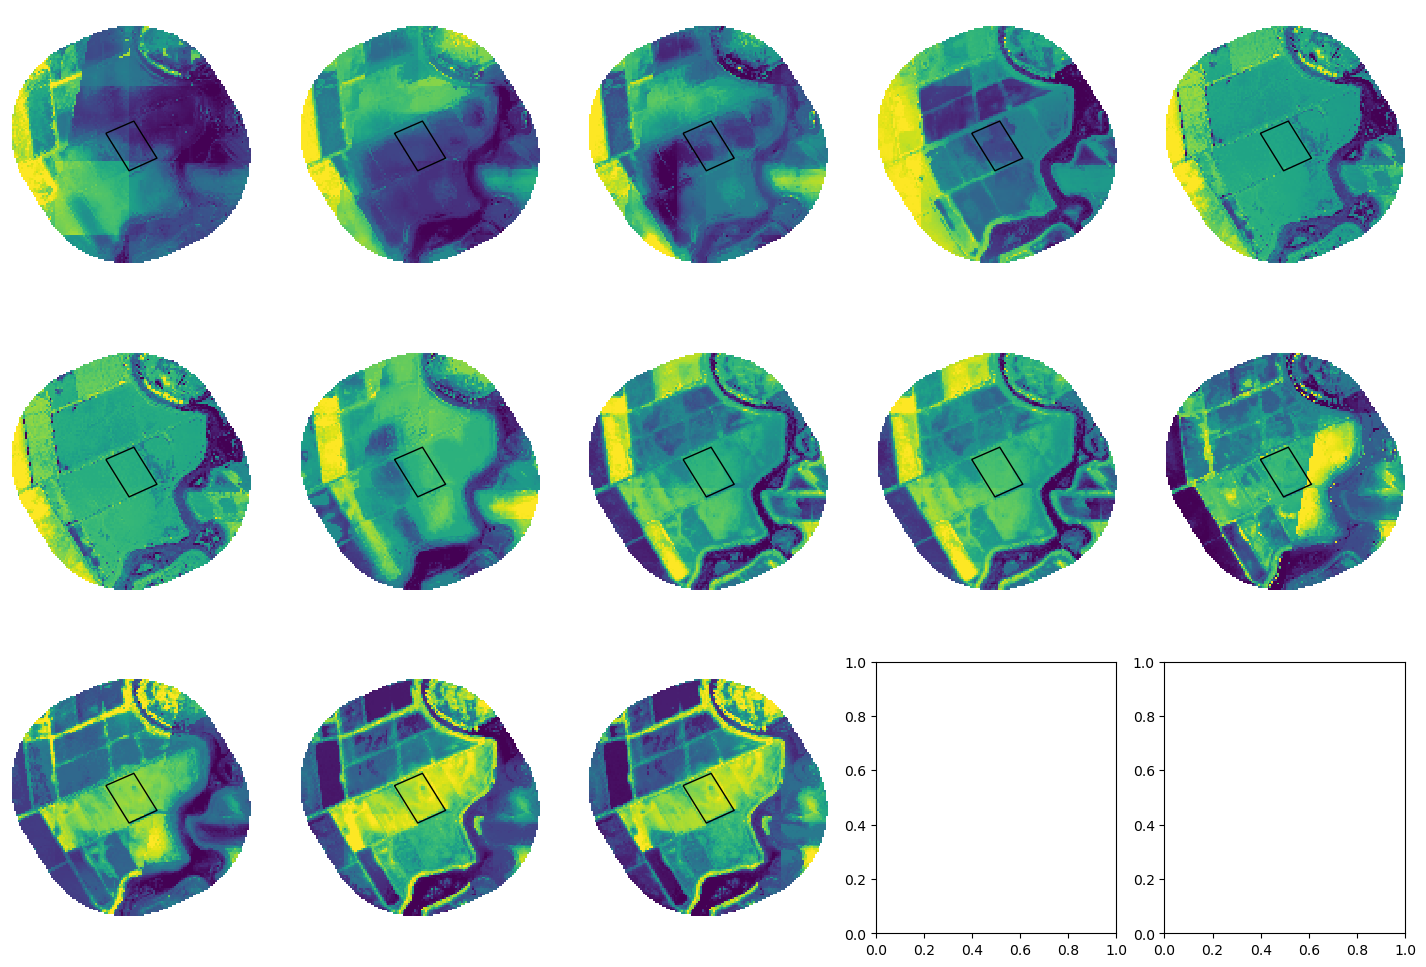

In [267]:
fig, axes = plt.subplots(3,5, figsize=(18,12))
axes = axes.flat

for i, timestamp in enumerate(selected_data_array1['time']):
    image = lst_clip_sel.sel(time=timestamp)
    im = image.plot.imshow(ax=axes[i], robust=True)
    poly_gdf.plot(ax=axes[i], facecolor='none', edgecolor='black')

    axes[i].set_axis_off()
    axes[i].axis('equal')
    axes[i].set_title('')

    im.colorbar.remove()

## CATD
Finally, we'll explore whether CATD provides an earlier signal of the dry up than the NDVI.

In [ ]:
# Plot raster
fig, ax = plt.subplots(figsize=(10, 10))

data_array.plot.imshow(ax=ax, add_colorbar=True)
poly_gdf.plot(ax=ax, facecolor='none', edgecolor='black')
ctx.add_basemap(ax, crs=poly_gdf.crs, source=ctx.providers.Esri.WorldImagery, alpha=0.5)

# Format axes
ax.set_title('Alfalfa')
ax.set(xticks=[], yticks=[], xlabel='', ylabel='')
ax.axes.set_aspect('equal')
ax.set_axis_off()


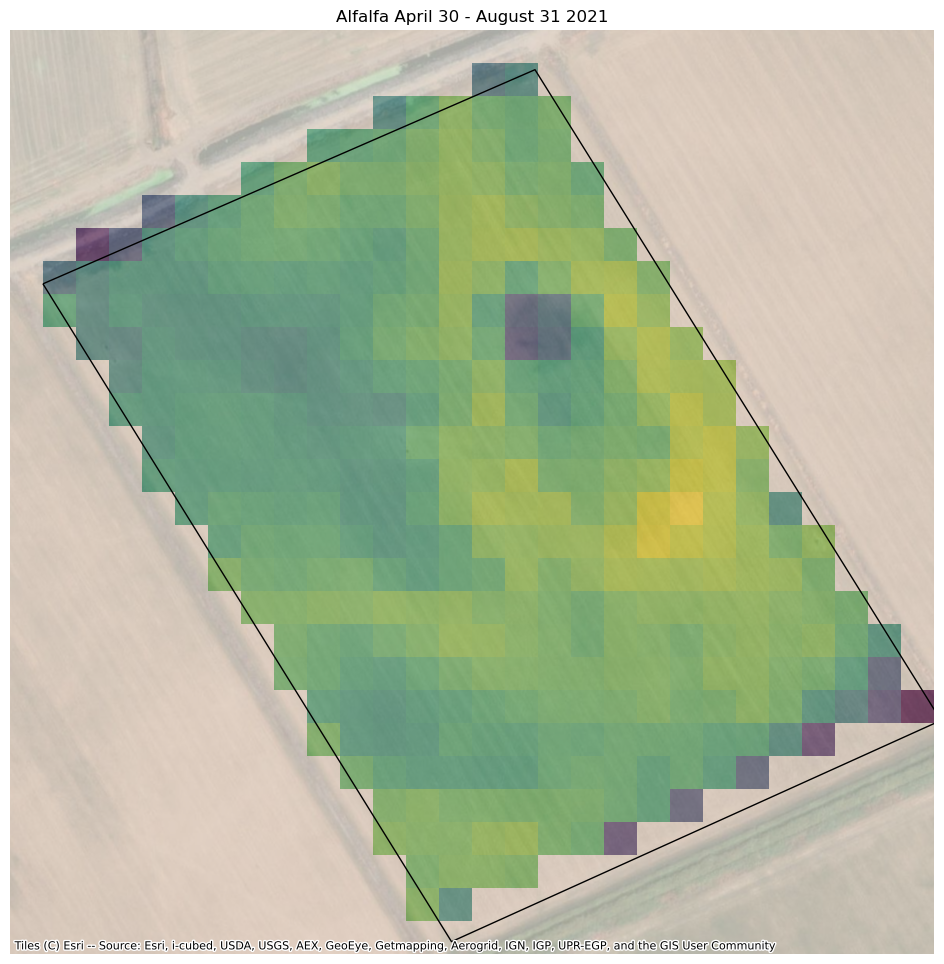

In [10]:
# Open the file with Rasterio
Session = rasterio.Env()

with Session:
    with rasterio.open(filepath) as src:
        out_image, out_transform = rasterio.mask.mask(src, poly_gdf.geometry.apply(mapping), crop=True)
        out_meta = src.meta

        # Update metadata after mask
        out_meta.update({"driver": "GTiff",
                        "height": out_image.shape[1],
                        "width": out_image.shape[2],
                        "transform": out_transform})

        # Assign coordinate values from out_meta
        coords = {
            "x": out_meta["transform"].c + out_meta["transform"].a * np.arange(out_meta["width"]),
            "y": out_meta["transform"].f + out_meta["transform"].e * np.arange(out_meta["height"])
        }

        # Create a new DataArray with updated coordinates
        data_array = xr.DataArray(
            out_image.squeeze(),
            coords=coords,
            dims=("y", "x"),  # Update dimensions as per your data shape
        )

        # Set the CRS (Coordinate Reference System) for the DataArray
        data_array.rio.set_crs(out_meta["crs"])
        fig, ax = plt.subplots(1, 1, figsize=(12,12))
        im = data_array.plot.imshow(ax=ax, add_colorbar=False, animated=True)
        poly_gdf.plot(ax=ax, facecolor='none', edgecolor='black')
        ctx.add_basemap(ax, crs=poly_gdf.crs, source=ctx.providers.Esri.WorldImagery, alpha=0.5)

        # Format axes
        ax.set_title('Alfalfa April 30 - August 31 2022')
        ax.set(xticks=[], yticks=[], xlabel='', ylabel='')
        ax.axes.set_aspect('equal')
        ax.set_axis_off()

In [11]:
# import IPython.display
#Sort the results in time
features = itemjson['features']
# IPython.display.JSON(features)
assetlist = {}
for f in features:
    assetlist.update( {f["properties"]["datetime"] : f["assets"]["lst"]["href"]})  


In [12]:
sorted(assetlist.keys())

['2022-04-30T00:00:00Z',
 '2022-05-01T00:00:00Z',
 '2022-05-02T00:00:00Z',
 '2022-05-05T00:00:00Z',
 '2022-05-06T00:00:00Z',
 '2022-05-07T00:00:00Z',
 '2022-05-08T00:00:00Z',
 '2022-05-09T00:00:00Z',
 '2022-05-10T00:00:00Z',
 '2022-05-13T00:00:00Z',
 '2022-05-14T00:00:00Z',
 '2022-05-15T00:00:00Z',
 '2022-05-16T00:00:00Z',
 '2022-05-17T00:00:00Z',
 '2022-05-18T00:00:00Z',
 '2022-05-21T00:00:00Z',
 '2022-05-22T00:00:00Z',
 '2022-05-23T00:00:00Z',
 '2022-05-24T00:00:00Z',
 '2022-05-25T00:00:00Z',
 '2022-05-26T00:00:00Z',
 '2022-05-29T00:00:00Z',
 '2022-05-30T00:00:00Z',
 '2022-05-31T00:00:00Z',
 '2022-06-01T00:00:00Z',
 '2022-06-02T00:00:00Z',
 '2022-06-03T00:00:00Z',
 '2022-06-06T00:00:00Z',
 '2022-06-07T00:00:00Z',
 '2022-06-08T00:00:00Z',
 '2022-06-09T00:00:00Z',
 '2022-06-10T00:00:00Z',
 '2022-06-11T00:00:00Z',
 '2022-06-14T00:00:00Z',
 '2022-06-15T00:00:00Z',
 '2022-06-16T00:00:00Z',
 '2022-06-17T00:00:00Z',
 '2022-06-18T00:00:00Z',
 '2022-06-19T00:00:00Z',
 '2022-06-22T00:00:00Z',


In [21]:
%matplotlib notebook
import numpy as np
import rasterio
from rasterio.windows import Window
import matplotlib.animation as animation
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(12,12))
# ctx.add_basemap(ax, crs=poly_gdf.crs, source=ctx.providers.Esri.WorldImagery, alpha=0.5)

# Open the file with Rasterio
Session = rasterio.Env(
            GDAL_DISABLE_READDIR_ON_OPEN='YES',
            CPL_VSIL_CURL_USE_HEAD='NO',
            )
ims=[]
for key in sorted(assetlist.keys()):   
    with Session:
        filepath = assetlist[key]
        timestamp = key
        with rasterio.open(filepath) as src:
            out_image, out_transform = rasterio.mask.mask(src, poly_gdf.geometry.apply(mapping), crop=True)
            out_meta = src.meta

            # Update metadata after mask
            out_meta.update({"driver": "GTiff",
                            "height": out_image.shape[1],
                            "width": out_image.shape[2],
                            "transform": out_transform})

            # Assign coordinate values from out_meta
            coords = {
                "x": out_meta["transform"].c + out_meta["transform"].a * np.arange(out_meta["width"]),
                "y": out_meta["transform"].f + out_meta["transform"].e * np.arange(out_meta["height"])
            }

            # Create a new DataArray with updated coordinates
            data_array = xr.DataArray(
                out_image.squeeze(),
                coords=coords,
                dims=("y", "x"),  # Update dimensions as per your data shape
            )

            # Set the CRS (Coordinate Reference System) for the DataArray
            data_array.rio.set_crs(out_meta["crs"])

            
            im = data_array.plot.imshow(ax=ax, add_colorbar=False, animated=True)
            poly_gdf.plot(ax=ax, facecolor='none', edgecolor='black')
            

            # Format axes
            ax.set_title('Alfalfa April 30 - August 31 2022')
            ax.set(xticks=[], yticks=[], xlabel='', ylabel='')
            ax.axes.set_aspect('equal')
            ax.set_axis_off()
            
            ims.append([im])
            
ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=500)

ani.save('anim.gif', writer="imagemagick")

<IPython.core.display.Javascript object>

MovieWriter imagemagick unavailable; using Pillow instead.


In [ ]:
assets = s2_items[0].to_dict()['assets'].keys()
res_full = FH_Hydrosat(s2_items, asset='surface_reflectance')
res_dt = res_full.datetime

In [ ]:
import folium

m = folium.Map()

folium.Marker(location = [crop_center_points['Alfalfa'][1], crop_center_points['Alfalfa'][0]]).add_to(m)

# Add polygons to the map
for idx, row in poly_gdf.to_crs(4326).iterrows():
    geojson = row.geometry.__geo_interface__
    folium.GeoJson(geojson).add_to(m)

m.fit_bounds(m.get_bounds())
m

In [ ]:
res_full = FH_Hydrosat(items, asset='surface_reflectance')
res_stack = res_full.stack()

In [ ]:
poly = Polygon(config[met_tower]['aoi_coordinates'])
poly_gdf = gpd.GeoDataFrame({'geometry':[poly]}, crs=CRS.from_epsg(4326))
poly_gdf = poly_gdf.to_crs(crs = CRS.from_epsg(32610))
poly_gdf_buffer = poly_gdf.buffer(1000)
poly_gdf_buffer

In [ ]:
res_clip = FH_StackedDataset(res_stack.ds.rio.clip(poly_gdf_buffer.geometry))

In [ ]:
red_band = res_stack.ds.isel(band=2)[10]
green_band = res_stack.ds.isel(band=1)[10]
blue_band = res_stack.ds.isel(band=0)[10]

def normalize(arr):
    return (arr - arr.min()) / (arr.max() - arr.min())

red_band_norm = normalize(red_band)
green_band_norm = normalize(green_band)
blue_band_norm = normalize(blue_band)

rgb_image = xr.concat([red_band_norm, green_band_norm, blue_band_norm], dim='band')

rgb_image.plot.imshow(robust=True)
plt.show()


In [ ]:
def normalize(arr):
    return (arr - arr.min()) / (arr.max() - arr.min())

res_rgb = res_clip.ds.isel(band=[2,1,0])[10]
res_rgb_norm = normalize(res_rgb)
res_rgb_norm.plot.imshow(robust=True)

In [ ]:
# Extract by point with tolerance
# Read pt into geodataframe and convert crs
pt_gdf = (gpd.GeoDataFrame(index=[0], crs='epsg:4326', geometry=[pt])
          .to_crs(32610))

# Extract time series 
lon = pt_gdf.geometry[0].x
lat = pt_gdf.geometry[0].y
tol = 750
# modis_ndvi_series = modis_ndvi.interp(x=lon, y=lat, method='linear', 
#                                       kwargs={'fill_value': None})
modis_ndvi_series = modis_ndvi.sel(x=lon, y=lat, method='nearest', tolerance=tol)
modis_ndvi_series

In [ ]:
# Replicate Hydrosat approach with slice
set_x = pt_gdf.geometry[0].x
set_y = pt_gdf.geometry[0].y
tol = 750
pad = 1

xslice = slice(set_x-pad*tol, set_x+pad*tol)
yslice = slice(set_y+pad*tol, set_y-pad*tol)
red_ts = modis_comp_clip.isel(band=0).sel(x=xslice, y=yslice).mean(dim=('x', 'y'))
nir_ts = modis_comp_clip.isel(band=1).sel(x=xslice, y=yslice).mean(dim=('x', 'y'))

ndvi_ts = (np.array(nir_ts) - np.array(red_ts)) / (np.array(nir_ts) + np.array(red_ts))
ndvi_ts = (nir_ts - red_ts) / (nir_ts + red_ts)
ndvi_ts

In [ ]:
s2_ndvi.plot(x='x', y='y', col='time', col_wrap=5, cmap='RdYlGn', vmin=0, vmax=1)

In [ ]:
# Find common dates for prepped collections
s2_time_values = s2_comp_clip['time'].values.astype('datetime64[D]')
modis_time_values = modis_comp_clip['time'].values.astype('datetime64[D]')
lst_time_values = lst_clip['time'].values.astype('datetime64[D]')

s2_modis_common = np.intersect1d(s2_time_values, modis_time_values)

common_dates = np.intersect1d(s2_modis_common, lst_time_values)

In [ ]:
# Plot side-by-side comparisons
fig, axes = plt.subplots(13,6, figsize=(12,24))

for i, timestamp in enumerate(common_dates):
    # Plot RBG
    ax_col = 0
    image = s2_comp_rgb.sel(time=s2_comp_rgb['time'].values.astype('datetime64[D]') == timestamp.astype('datetime64[D]'))[0]
    image.plot.imshow(ax=axes[i][ax_col], robust=True)
    poly_gdf.plot(ax=axes[i][ax_col], facecolor='none', edgecolor='black')

    # Plot Sentinel-2 NDVI
    ax_col = 1
    mask = s2c_ndvi['time'].values.astype('datetime64[D]') == timestamp.astype('datetime64[D]')
    image = s2c_ndvi.sel(time=mask)[0]
    im_s2_ndvi = image.plot.imshow(ax=axes[i][ax_col], robust=True, vmin=-1, vmax=1, cmap='RdYlGn')
    poly_gdf.plot(ax=axes[i][ax_col], facecolor='none', edgecolor='black')

    # im_s2_ndvi.colorbar.remove()
    
    # Plot MODIS data
    ax_col = 2
    mask = modis_ndvi['time'].values.astype('datetime64[D]') == timestamp.astype('datetime64[D]')
    image = modis_ndvi.sel(time=mask)[0]
    im_s2_ndvi = image.plot.imshow(ax=axes[i][ax_col], robust=True, vmin=-1, vmax=1, cmap='RdYlGn')
    poly_gdf.plot(ax=axes[i][ax_col], facecolor='none', edgecolor='black')

    # im_s2_ndvi.colorbar.remove()

    # Plot LST
    ax_col = 3
    mask = lst_clip['time'].values.astype('datetime64[D]') == timestamp.astype('datetime64[D]')
    image = lst_clip.sel(time=mask)[0]
    im_s2_ndvi = image.plot.imshow(ax=axes[i][ax_col], robust=True)
    poly_gdf.plot(ax=axes[i][ax_col], facecolor='none', edgecolor='black')

    # im_s2_ndvi.colorbar.remove()
    

for ax in axes.flatten():
    ax.set_axis_off()
    ax.axis('equal')
    ax.set_title('')
    

In [ ]:
# Calc NDVI from MODIS composite data
modis_ndvi = calc_ndvi(modis_comp_clip, red_band=0, nir_band=1)
modis_ndvi = modis_ndvi.rio.set_crs(CRS.from_epsg(32610))

# modis_ndvi_field = modis_ndvi.rio.clip(poly_gdf.geometry, all_touched=True, drop=True)

# modis_ndvi_field.mean(dim=('x', 'y')).plot(linestyle='--', alpha=0.3, marker='o', c='y', label='MODIS Composite')
# ndvi_ts.plot(linestyle='--', alpha=0.3, marker='o', c='g', label='MODIS Composite NDVI')